<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/Food_Vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 101 Food Vision Classification

## import libraries:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## checking the GPU to see if it supports mixed precision

In [ ]:
!nvidia-smi

Sat Mar 19 07:28:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-24 02:35:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-24 02:35:29 (54.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys 

## Tensorflow Datasets

In [55]:
dataset_list = tfds.list_builders()
dataset_list [:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

## importing food 101 dataset

In [4]:
(train_data,test_data), ds_info = tfds.load('food101',
                                            split=['train','validation'],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True,
                                            batch_size=32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete3NTKQZ/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete3NTKQZ/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [44]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
for images , labels in test_data:
  print(images.shape, labels)
  break

(32, 512, 512, 3) tf.Tensor(
[37 99 40 60  1 69 52 62 77 67 12 96 53 70 44 71 93 83 98 40 60 13 36 92
 21 25 29 81 66 81  1 92], shape=(32,), dtype=int64)


(512, 512, 3) <dtype: 'uint8'>


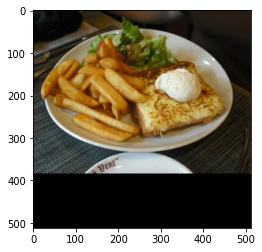

In [43]:
for image , label in test_data.take(1):
  img = image[0]
  print(img.shape, img.dtype)
  # print(tf.reduce_max(img))
  # img = tf.image.rot90(img, k=1)
  plt.imshow(img)


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [ ]:
ds_info.supervised_keys

('image', 'label')

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
ds_info.features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
def preprocess_img(image, image_size = 224):
  new_image = tf.image.Resize(image, size= (image_size, image_size))
  tf.cast(new_image, dtype = tf.float32)
  return new_image 

In [46]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [45]:
for image , label in train_data.take(1):
  print(f'''shape: {image.shape}
  tyep: {image.dtype}
  label : {label}''')
  #class name : {class_names[label.numpy()]}''')

shape: (32, 512, 512, 3)
  tyep: <dtype: 'uint8'>
  label : [ 16  71  36  89  93  70  30  27  18  63  84  51  91  59  64  95  77  11
  96 100  18  59  80  76  22  43  76  33   2  92   8  48]


In [ ]:
image[0]

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   

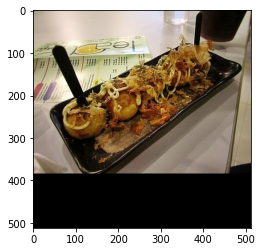

In [ ]:
plt.imshow(image[0])

In [47]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [54]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## data augmentation

In [52]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.Resizing(224,224),
                    # tf.keras.layers.Rescaling(1/255), # efficientnet has built-in rescaling
                    tf.keras.layers.RandomFlip('horizontal'),
                    tf.keras.layers.RandomRotation(0.1)],
                    # tf.keras.layers.RandomZoom(0.2),
                    # tf.keras.layers.RandomHeight(0.2),
                    # tf.keras.layers.RandomWidth(0.2)], 
                    name ="data_augmentation")

## Model Callbacks

In [58]:
checkpointPath = '/checkpoint/FoodVision'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(checkpointPath, 
                                                     monitor='val_acc', 
                                                     save_best_only=True,
                                                     save_weights_only=True)